In [1]:
import os
import copy
from dataclasses import dataclass

import numpy as np
import torch
from datasets import Dataset, load_dataset, concatenate_datasets
from datasets.features import Value
from transformers import (
    BitsAndBytesConfig,
    Gemma2ForSequenceClassification,
    GemmaTokenizerFast,
    Gemma2Config,
    PreTrainedTokenizerBase, 
    EvalPrediction,
    Trainer,
    TrainingArguments,
    DataCollatorWithPadding,
)
from peft import LoraConfig, get_peft_model, prepare_model_for_kbit_training, TaskType
from sklearn.metrics import log_loss, accuracy_score
from transformers.integrations import TensorBoardCallback
from tqdm import tqdm

In [2]:
# parameters here for training and lora config 
class Config:
    output_dir: str = "gemma-2-9b-train-tta-lora-mods-33k"
    checkpoint: str = "unsloth/gemma-2-9b-it-bnb-4bit" 
    max_length: int = 2048
    n_splits: int = 5
    fold_idx: int = 0
    optim_type: str = "adamw_8bit"
    per_device_train_batch_size: int = 2
    gradient_accumulation_steps: int = 2  
    per_device_eval_batch_size: int = 8
    n_epochs: int = 1
    freeze_layers: int = 0 # changed to 0 
    lr: float = 2e-4 #  LR=2e-4 1 epoch linear schedule with warmup, then a=4 is best alpha for all rank. 
    warmup_steps: int = 20
    lora_r: int = 64  # changed to 64, or 1024
    lora_alpha: float = 4 # changed to 16, or 4 next 
    lora_dropout: float = 0.05
    lora_bias: str = "none"
    
config = Config()

In [3]:
lora_config = LoraConfig(
    r=config.lora_r,
    lora_alpha=config.lora_alpha,
    # only target self-attention
    target_modules=["q_proj", "k_proj", "v_proj", "down_proj","up_proj","o_proj","gate_proj"], # added more target layers
    layers_to_transform=[i for i in range(42) if i >= config.freeze_layers],
    lora_dropout=config.lora_dropout,
    bias=config.lora_bias,
    task_type=TaskType.SEQ_CLS,
)

In [4]:
# instantiate tokenizer and model 
tokenizer = GemmaTokenizerFast.from_pretrained(config.checkpoint)
tokenizer.add_eos_token = True  # We'll add <eos> at the end
tokenizer.padding_side = "right"

In [5]:
model = Gemma2ForSequenceClassification.from_pretrained(
    config.checkpoint,
    num_labels=3,
    torch_dtype=torch.float16,
    device_map="auto",
)
model.config.use_cache = False
model = prepare_model_for_kbit_training(model)
model = get_peft_model(model, lora_config)
model

Unused kwargs: ['_load_in_4bit', '_load_in_8bit', 'quant_method']. These kwargs are not used in <class 'transformers.utils.quantization_config.BitsAndBytesConfig'>.
Some weights of Gemma2ForSequenceClassification were not initialized from the model checkpoint at unsloth/gemma-2-9b-it-bnb-4bit and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


PeftModelForSequenceClassification(
  (base_model): LoraModel(
    (model): Gemma2ForSequenceClassification(
      (model): Gemma2Model(
        (embed_tokens): Embedding(256000, 3584, padding_idx=0)
        (layers): ModuleList(
          (0-41): 42 x Gemma2DecoderLayer(
            (self_attn): Gemma2Attention(
              (q_proj): lora.Linear4bit(
                (base_layer): Linear4bit(in_features=3584, out_features=4096, bias=False)
                (lora_dropout): ModuleDict(
                  (default): Dropout(p=0.05, inplace=False)
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=3584, out_features=64, bias=False)
                )
                (lora_B): ModuleDict(
                  (default): Linear(in_features=64, out_features=4096, bias=False)
                )
                (lora_embedding_A): ParameterDict()
                (lora_embedding_B): ParameterDict()
                (lora_magnitude_vector): ModuleDic

In [6]:
model.print_trainable_parameters()

trainable params: 216,082,944 || all params: 9,457,799,680 || trainable%: 2.2847


In [7]:
dataset = load_dataset("lmsys/lmsys-arena-human-preference-55k")
current_features = dataset['train'].features
current_features['id'] = Value('string')
dataset['train'] = dataset['train'].cast(current_features)
dataset['train'].features

{'id': Value(dtype='string', id=None),
 'model_a': Value(dtype='string', id=None),
 'model_b': Value(dtype='string', id=None),
 'prompt': Value(dtype='string', id=None),
 'response_a': Value(dtype='string', id=None),
 'response_b': Value(dtype='string', id=None),
 'winner_model_a': Value(dtype='int64', id=None),
 'winner_model_b': Value(dtype='int64', id=None),
 'winner_tie': Value(dtype='int64', id=None)}

In [8]:
dataset_33k = Dataset.from_csv("lmsys-33k-deduplicated.csv")
dataset_33k.features

{'id': Value(dtype='string', id=None),
 'model_a': Value(dtype='string', id=None),
 'model_b': Value(dtype='string', id=None),
 'prompt': Value(dtype='string', id=None),
 'response_a': Value(dtype='string', id=None),
 'response_b': Value(dtype='string', id=None),
 'winner_model_a': Value(dtype='int64', id=None),
 'winner_model_b': Value(dtype='int64', id=None),
 'winner_tie': Value(dtype='int64', id=None)}

In [9]:
dataset = concatenate_datasets([dataset['train'], dataset_33k])
dataset

Dataset({
    features: ['id', 'model_a', 'model_b', 'prompt', 'response_a', 'response_b', 'winner_model_a', 'winner_model_b', 'winner_tie'],
    num_rows: 78664
})

In [10]:
class CustomTokenizer:
    def __init__(
        self, 
        tokenizer: PreTrainedTokenizerBase, 
        max_length: int
    ) -> None:
        self.tokenizer = tokenizer
        self.max_length = max_length
        
    def __call__(self, batch: dict) -> dict:
        prompt = ["<prompt>: " + self.process_text(t) for t in batch["prompt"]]
        response_a = ["\n\n<response_a of a gpt-4>: " + self.process_text(t) for t in batch["response_a"]]
        response_b = ["\n\n<response_b of a bird>: " + self.process_text(t) for t in batch["response_b"]]
        texts = [p + r_a + r_b for p, r_a, r_b in zip(prompt, response_a, response_b)]
        tokenized = self.tokenizer(texts, max_length=self.max_length, truncation=True)
        labels=[]
        for a_win, b_win in zip(batch["winner_model_a"], batch["winner_model_b"]):
            if a_win:
                label = 0
            elif b_win:
                label = 1
            else:
                label = 2
            labels.append(label)
        return {**tokenized, "labels": labels}
        
    @staticmethod
    def process_text(text: str) -> str:
        return " ".join(eval(text, {"null": ""}))

In [11]:
encode = CustomTokenizer(tokenizer, max_length=config.max_length)
dataset = dataset.map(encode, batched=True)

In [12]:
def compute_metrics(eval_preds: EvalPrediction) -> dict:
    preds = eval_preds.predictions
    labels = eval_preds.label_ids
    probs = torch.from_numpy(preds).float().softmax(-1).numpy()
    loss = log_loss(y_true=labels, y_pred=probs)
    acc = accuracy_score(y_true=labels, y_pred=preds.argmax(-1))
    return {"acc": acc, "log_loss": loss}

In [13]:
eval_idx = [i for i in range(57477) if i % 5 == 0]  # Get every 5th index
train_idx = [i for i in range(len(dataset)) if i not in eval_idx]

# If you want to print the lengths of the arrays to verify
print(f"Number of evaluation indices: {len(eval_idx)}")
print(f"Number of training indices: {len(train_idx)}")

Number of evaluation indices: 11496
Number of training indices: 67168


In [14]:
eval_dataset=dataset.select(eval_idx)
eval_dataframe = eval_dataset.to_pandas()
eval_dataframe.head()

,id,model_a,model_b,prompt,response_a,response_b,winner_model_a,winner_model_b,winner_tie,input_ids,attention_mask,labels
0,30192,gpt-4-1106-preview,gpt-4-0613,"[""Is it morally right to try to have a certain...","[""The question of whether it is morally right ...","[""As an AI, I don't have personal beliefs or o...",1,0,0,"[2, 235322, 39038, 78880, 2125, 665, 89397, 18...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",0
1,292873,vicuna-13b,gpt-4-0314,"[""Construct a rap battle, in the style of Epic...","[""[Zeus]\nYo, it's the king of the gods on the...","[""(Verse 1 - Zeus)\n\nI'm the king of the gods...",0,1,0,"[2, 235322, 39038, 78880, 58863, 476, 13483, 9...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",1
2,497862,vicuna-7b,guanaco-33b,"[""write a python function to upload all the fi...","[""Sure, here's a Python function that uses the...","[""Sure, here's an example function in Python t...",0,1,0,"[2, 235322, 39038, 78880, 5598, 476, 17706, 14...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",1
3,863398,llama2-70b-steerlm-chat,gemini-pro-dev-api,"[""what do you know about real estate""]","[""Real estate refers to the land and buildings...","[""1. **Types of Real Estate:**\n * **Reside...",0,1,0,"[2, 235322, 39038, 78880, 1212, 749, 692, 1230...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",1
4,1256092,claude-2.1,vicuna-13b,"[""Write a python code that calculates sum of 5...","[""Here is the python code that calculates the ...","[""Here is a Python code that calculates the su...",0,0,1,"[2, 235322, 39038, 78880, 15615, 476, 17706, 3...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",2


In [25]:
from torch.utils.data import DataLoader

train_dataset = dataset.select(train_idx)
eval_dataset = dataset.select(eval_idx)

train_batch_size = training_args.per_device_train_batch_size
eval_batch_size = training_args.per_device_eval_batch_size

train_loader = DataLoader(
    train_dataset, 
    batch_size=train_batch_size, 
    shuffle=True
)

val_loader = DataLoader(
    eval_dataset, 
    batch_size=eval_batch_size, 
    shuffle=False,
)

In [28]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import AdamW
from peft import get_peft_model, LoraConfig
from torch.utils.tensorboard import SummaryWriter
import os
import json

# Device setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# model define above 

# Send the model to device (GPU or CPU)
model = model.to(device)

# Criterion and optimizer
criterion = nn.CrossEntropyLoss().to(device)
optimizer = AdamW(model.parameters(), lr=config.lr)
writer = SummaryWriter(training_args.logging_dir)

# Training loop
best_accuracy = 0.0
global_step = 0

for epoch in range(training_args.num_train_epochs):
    model.train()
    running_loss = 0.0
    correct_preds = 0
    total_samples = 0

    # Loop through batches
    for step, batch in enumerate(train_loader):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        # Forward pass
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        logits = outputs.logits

        # Backpropagation with gradient accumulation
        loss.backward()

        # Perform optimization step every `gradient_accumulation_steps`
        if (step + 1) % training_args.gradient_accumulation_steps == 0:
            optimizer.step()
            scheduler.step()
            optimizer.zero_grad()

        running_loss += loss.item()

        # Calculate accuracy
        preds = torch.argmax(logits, dim=-1)
        correct_preds += (preds == labels).sum().item()
        total_samples += labels.size(0)

        # Log progress to TensorBoard every `logging_steps`
        if global_step % training_args.logging_steps == 0:
            writer.add_scalar("Loss/Train", loss.item(), global_step)
            writer.add_scalar("Accuracy/Train", correct_preds / total_samples, global_step)

        global_step += 1

    # Validation step after each epoch
    model.eval()
    val_loss = 0.0
    val_correct_preds = 0
    val_total_samples = 0
    with torch.no_grad():
        for val_batch in val_loader:
            input_ids = val_batch['input_ids'].to(device)
            attention_mask = val_batch['attention_mask'].to(device)
            labels = val_batch['labels'].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            val_loss += outputs.loss.item()

            preds = torch.argmax(outputs.logits, dim=-1)
            val_correct_preds += (preds == labels).sum().item()
            val_total_samples += labels.size(0)

    val_accuracy = val_correct_preds / val_total_samples
    val_loss /= len(val_loader)

    # Log validation results
    writer.add_scalar("Loss/Validation", val_loss, epoch)
    writer.add_scalar("Accuracy/Validation", val_accuracy, epoch)

    # Print progress
    print(f'Epoch [{epoch+1}/{training_args.num_train_epochs}], Loss: {running_loss/len(train_loader)}, Val Loss: {val_loss}, Val Accuracy: {val_accuracy}')

    # Save best model if accuracy improves
    if val_accuracy > best_accuracy:
        best_accuracy = val_accuracy
        model_save_path = os.path.join(training_args.output_dir, f'best_model_epoch_{epoch+1}_val_acc_{best_accuracy:.4f}.pth')
        torch.save(model.state_dict(), model_save_path)

# Save the final model and close the tensorboard writer
torch.save(model.state_dict(), os.path.join(training_args.output_dir, 'final_model.pth'))
writer.close()

RuntimeError: each element in list of batch should be of equal size

In [16]:
training_args = TrainingArguments(
    output_dir="output",
    overwrite_output_dir=True,
    report_to="tensorboard",  # Enable reporting to TensorBoard
    num_train_epochs=config.n_epochs,
    per_device_train_batch_size=config.per_device_train_batch_size,
    gradient_accumulation_steps=config.gradient_accumulation_steps,
    per_device_eval_batch_size=config.per_device_eval_batch_size,
    logging_steps=10,  # Log every 10 steps
    logging_dir='./logs/gemma-2-9b-train-tta-lora-mods-33k-2048-random-words',  # Directory for TensorBoard logs
    eval_strategy="steps",  # Evaluate every specific number of steps
    eval_steps=5000,  # Evaluate every 2000 steps
    save_strategy="steps",
    save_steps=5000,
    metric_for_best_model="eval_acc",  # Save based on eval accuracy
    optim=config.optim_type,
    fp16=True,
    learning_rate=config.lr,
    warmup_steps=config.warmup_steps,
)

In [17]:
trainer = Trainer(
    args=training_args, 
    model=model,
    tokenizer=tokenizer,
    train_dataset=dataset.select(train_idx),
    eval_dataset=dataset.select(eval_idx),
    compute_metrics=compute_metrics,
    data_collator=DataCollatorWithPadding(tokenizer=tokenizer),
    callbacks=[TensorBoardCallback()],
)
trainer.train()

/tmp/ipykernel_214493/2740791879.py:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.
You are adding a <class 'transformers.integrations.integration_utils.TensorBoardCallback'> to the callbacks of this Trainer, but there is already one. The currentlist of callbacks is
:DefaultFlowCallback
TensorBoardCallback
/home/skunk/miniconda3/lib/python3.12/site-packages/torch/utils/checkpoint.py:464: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs 

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:1 and cuda:0! (when checking argument for argument target in method wrapper_CUDA_nll_loss_forward)

In [ ]:
eval_dataset=dataset.select(eval_idx)
predictions = trainer.predict(eval_dataset)
pred_labels = np.argmax(predictions.predictions, axis=1)  # Get the predicted class (3-way classification)
true_labels = predictions.label_ids  # Get the true class labels

# Compute confusion matrix
cm = confusion_matrix(true_labels, pred_labels, labels=[0, 1, 2])

# Plotting the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Model A Win', 'Model B Win', 'Tie'])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix for 3-Way Model Classification')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

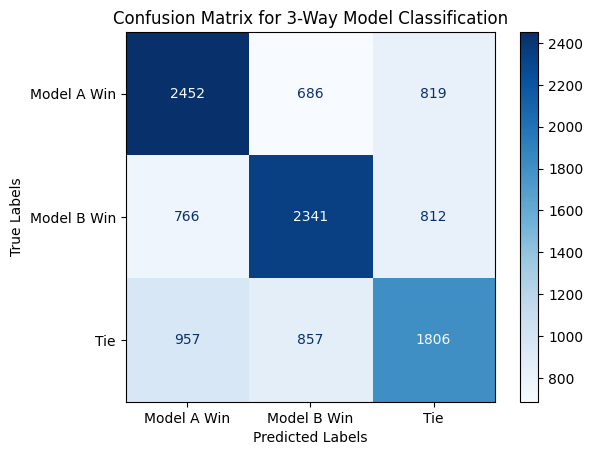

In [19]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Compute confusion matrix
cm = confusion_matrix(true_labels, pred_labels, labels=[0, 1, 2])

# Plotting the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Model A Win', 'Model B Win', 'Tie'])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix for 3-Way Model Classification')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()